In [2]:
from multicontact_api import ContactSequenceHumanoid
from database import *
from memmo_utils import *

import numpy as np
import rospy
from IPython.display import clear_output

from regression import *
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4,suppress=True)

import matplotlib.pyplot as plt

from visualization_msgs.msg import MarkerArray
from std_msgs.msg._ColorRGBA import ColorRGBA
import os

from memmo_utils import *
from sklearn.mixture import GaussianMixture
import pickle
import transforms3d

#### Initialise visualisation 

In [3]:
viz = Visual()
#rospy.init_node('foot_markers')
foot_marker = RvizMarker(name='marker_array')

object_marker = RvizMarker(name='objects_marker', marker_type = Marker.CUBE, n = 5, max_n = 5, scale = Vector3(1.2,1.2,1.2), duration=13000)

#### Add Objects to the scene 

In [25]:
object_marker.markers[0].type = Marker.CYLINDER
object_marker.markers[0].color = ColorRGBA(0,1,0,1)
object_marker.markers[0].scale = Vector3(2*.7,2*.7,2*.8)

object_marker.markers[1].color = ColorRGBA(1,0,0,1)
object_marker.markers[1].scale = Vector3(1.2,1.2,.8)


object_marker.markers[2].type = Marker.SPHERE
object_marker.markers[2].color = ColorRGBA(0,0,1,1)
object_marker.markers[2].scale = Vector3(2*.8,2*.8,2*.8)

object_marker.markers[3].type = Marker.SPHERE
object_marker.markers[3].color = ColorRGBA(1,1,1,1)
object_marker.markers[3].scale = Vector3(2*.9,2*.9,2*.9)

object_marker.markers[4].type = Marker.CYLINDER
object_marker.markers[4].color = ColorRGBA(0,0,0,1)
object_marker.markers[4].scale = Vector3(2*.7,2*.7,2*.8)

poses = []
poses += [np.array([0.5,-1,0,0.])]
poses += [np.array([0.9,2.,0,0.])]
poses += [np.array([-2.2,.3,0.4,0.])]
poses += [np.array([4.,0.,0.4,0.])]
poses += [np.array([-5,2,0.5,0.])]

object_marker.publish(poses)

In [5]:
def extract_contact_sequence(filename):
    cs = ContactSequenceHumanoid(0)
    cs.loadFromBinary(filename)
    raw_phases = cs.contact_phases

    T_lefts = []
    T_rights = []
    num_phases = len(raw_phases)
    for cur_phase in raw_phases:
        rf = cur_phase.RF_patch
        if rf.active:
            T_right = SE3toMat(rf.placement)
            T_rights += [T_right]
        else:
            T_rights += [None]
        lf = cur_phase.LF_patch
        if lf.active:
            T_left = SE3toMat(lf.placement)
            T_lefts += [T_left]
        else:
            T_lefts += [None]

    return T_lefts, T_rights

#### Load Contacts 

In [6]:
ROOT = '/home/rli/temp/talos_randomObstacle/'
filenames = os.listdir(ROOT)

In [7]:
foot_poses_list = []
len_contacts = []
num_error = 0
for i in range(len(filenames)):
    try:
        filename = ROOT + filenames[i] + '/res/contact_sequences/talos_randomObstacle.cs'
        T_l, T_r = extract_contact_sequence(filename)
        foot_poses = construct_foot_poses(T_l,T_r)
        foot_poses_list+= [foot_poses]
        len_contacts += [len(foot_poses)]
    except:
        num_error +=1 
        continue

In [8]:
len(foot_poses_list)

334

### Learning contact sequences 

#### Constructing the inputs

In [9]:
x_inputs = []
for i in range(len(foot_poses_list)):
    foot_pose = foot_poses_list[i]
    init_pos = 0.5*(foot_pose[0,:2]+foot_pose[1,:2])
    goal_pos = 0.5*(foot_pose[-2,:2]+foot_pose[-1,:2])
    x_input = np.hstack([init_pos, goal_pos])
    x_inputs += [x_input]
    
x_inputs = np.array(x_inputs)

#### Resample the outputs 

In [10]:
def angle_to_xy(foot_pose):
    foot_pose_mod = np.zeros((len(foot_pose),8))
    foot_pose_mod[:,0:2] = foot_pose[:,0:2]
    foot_pose_mod[:,4:6] = foot_pose[:,3:5]
    
    foot_pose_mod[:,2] = np.cos(foot_pose[:,2])
    foot_pose_mod[:,3] = np.sin(foot_pose[:,2])
    
    foot_pose_mod[:,6] = np.cos(foot_pose[:,5])
    foot_pose_mod[:,7] = np.sin(foot_pose[:,5])
    
    return foot_pose_mod
    
def xy_to_angle(foot_pose_mod):
    foot_pose = np.zeros((len(foot_pose_mod),6))
    foot_pose[:,0:2] = foot_pose_mod[:,0:2]
    foot_pose[:,3:5] = foot_pose_mod[:,4:6]
    
    foot_pose[:,2] = np.arctan2(foot_pose_mod[:,3],foot_pose_mod[:,2])
    foot_pose[:,5] = np.arctan2(foot_pose_mod[:,7],foot_pose_mod[:,6])
    
    return foot_pose

In [11]:
foot_pose_output = []
len_pose_output = []
num_steps = 200
for i in range(len(foot_poses_list)):
    foot_pose = foot_poses_list[i]
    foot_pose = foot_pose.reshape(-1,6)
    
    #skip every other footstep
    foot_pose = foot_pose[::2]
    len_pose_output += [len(foot_pose)]
    foot_pose = subsample(foot_pose,num_steps)
    
    #change the angle description to x and y
    foot_pose_mod = angle_to_xy(foot_pose) 
    
    foot_pose_output += [foot_pose_mod.flatten()]

foot_pose_output = np.array(foot_pose_output)
len_pose_output = np.array(len_pose_output)

#### Use RBF 

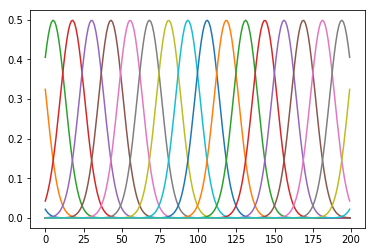

In [12]:
rbf_num_contact = 20
Phi_contact = define_RBF(dof=6, nbStates = rbf_num_contact, offset = 20, width = 8, T = num_steps, coeff = 10)
plt.plot(Phi_contact)
raw_input()
clear_output()

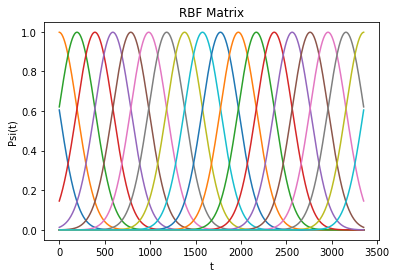

In [48]:
rbf_num_contact = 20
Phi_contact = define_RBF(dof=6, nbStates = rbf_num_contact, offset = 200, width = 200, T = 3351, coeff = 500)
clear_output()
plt.plot(Phi_contact)
plt.xlabel('t')
plt.ylabel('Psi(t)')
plt.title('RBF Matrix')
plt.savefig('/home/rli/temp/rbf.png')


In [13]:
w_poses = []
for foot_pose in foot_pose_output:
    foot_pose = foot_pose.reshape(-1,8)
    w,_,_,_ = np.linalg.lstsq(Phi_contact,foot_pose,rcond=1e-2)
    w_poses += [w.flatten()]
w_poses = np.array(w_poses)

#### Plot the RBF Results 

#### Train the regressors 

In [14]:
gpr_pose = GPy_Regressor(dim_input = 4)
gpr_len_pose = GPy_Regressor(dim_input = 4)
gpr_pose.fit(x_inputs,w_poses,num_restarts= 5)
gpr_len_pose.fit(x_inputs,len_pose_output[:,None],num_restarts = 5)
clear_output()

nn_pose = NN_Regressor()
nn_len_pose = NN_Regressor()
nn_pose.fit(x_inputs,w_poses[:,None])
nn_len_pose.fit(x_inputs,len_pose_output[:,None])

#### Approximate the input distributions 

In [15]:
gmm_input = GaussianMixture(n_components=10)
gmm_input.fit(x_inputs)
clear_output()

#### Test the Memory 

In [ ]:
for i in range(1):
    #obtain an input
    x_input,_ = gmm_input.sample()
    #x_input = x_inputs[i:i+1]
    
    #predict the foot_pose
    w_pose,_ = gpr_pose.predict(x_input)
    w_pose = w_pose.reshape(-1,8)
    foot_pose = np.dot(Phi_contact,w_pose)
    len_pose,_ = gpr_len_pose.predict(x_input)
    len_pose = int(len_pose[0,0])
    foot_pose = subsample(foot_pose,len_pose)
    
    #visualize the initial and goal location
    translation = (x_input[0,0],x_input[0,1],.1)
    rotation = (0,0,0,1)    
    viz.br.sendTransform(
        translation,rotation,rospy.Time.now(),"init","world")
    translation = (x_input[0,2],x_input[0,3],.1)
    rotation = (0,0,0,1)    
    viz.br.sendTransform(translation,rotation,rospy.Time.now(),"goal","world")

    #transform xy to angle
    foot_pose = xy_to_angle(foot_pose)
    foot_pose = foot_pose.reshape(-1,3)

    #add intermediate footstep
    foot_pose = add_intermediate(foot_pose)

    #publish
    foot_marker.publish(foot_pose)
    raw_input()
    clear_output()

### Predicting robot movements to follow the footsteps 

In [16]:
def move_foot_to_zero(foot_poses):
    init_pose = 0.5*(foot_poses[0]+foot_poses[1])
    T_init = PosetoMat(init_pose)
    T_init_inv = np.linalg.inv(T_init)
    foot_poses_mod = []
    for f in foot_poses:
        cur_pose = PosetoMat(f)
        cur_pose = np.dot(T_init_inv,cur_pose)
        foot_poses_mod += [MattoPose(cur_pose)]
    return np.array(foot_poses_mod)

def transform_foot_poses(foot_poses, T):
    foot_poses_mod = []
    for f in foot_poses:
        cur_pose = PosetoMat(f)
        cur_pose = np.dot(T,cur_pose)
        foot_poses_mod += [MattoPose(cur_pose)]
    return np.array(foot_poses_mod)

def toggle_key(key):
    if key == 'left': return 'right'
    if key == 'right': return 'left'

def add_intermediate(foot_poses):
    foot_poses = foot_poses.reshape(-1,6)
    cur_foot_pose = foot_poses[0].copy()
    foot_poses_mod = [cur_foot_pose.copy()]
    key = 'right'
    for i in range(1,len(foot_poses)):
        next_foot_pose = foot_poses[i].copy()
        if key == 'right':
            cur_foot_pose[3:] = next_foot_pose[3:]
        else:
            cur_foot_pose[:3] = next_foot_pose[:3]
        foot_poses_mod += [cur_foot_pose.copy()]
        foot_poses_mod += [next_foot_pose.copy()]
        cur_foot_pose = next_foot_pose.copy()
        #key = toggle_key(key)
    return np.array(foot_poses_mod).reshape(-1,3)
                

def calc_foot_T(x, move = 'left'):
    #calculate the footstep transformation matrix based on the input x
    #x is defined as: [left_foot, right_foot, 'foot_to_move']
    x = x.reshape(-1,3)
    Ts = []
    for x_i in x:
        T = PosetoMat(x_i)
        Ts.append(T)
    
    if move == 'left':
        T_lefts = [Ts[0], None, Ts[2]]
        T_rights = [Ts[1]]*3
    else:
        T_rights = [Ts[1], None, Ts[2]]
        T_lefts = [Ts[0]]*3
        
    return T_lefts, T_rights

def edit_foot_pose(foot_pose):
    n = len(foot_pose)/2
    for i in range(n-1):
        if i % 2 == 0:
            #left foot stationary
            foot_pose[2*i+2] = foot_pose[2*i]
        else:
            #right foot stationary
            foot_pose[2*i+3] = foot_pose[2*i+1]
    return foot_pose

In [17]:
def predict_multistep(foot_poses, func=None):
    traj_list = []
    foot_list = []
    T_lefts_list = []
    T_rights_list = []
    data_phases = []
    start_index = 0
    n = len(foot_poses)/2 - 1
    for i in range(n):
        cur_foot_pose = foot_poses[2*i:2*i+4,:].copy()
        
        foot_list.append(cur_foot_pose.copy())
        
        #modify the foot_pose according to the initial robot pose
        if i == 0:
            left_init = cur_foot_pose[0]
            right_init = cur_foot_pose[1]
            Twr = np.eye(4)
            Twr[:2,3] = 0.5*(left_init+right_init)[:2]
            angle = 0.5*(left_init+right_init)[2]
            Twr[:3,:3] = transforms3d.axangles.axangle2mat((0,0,1),angle)
        else:
            Twr = calc_root_pose(current_q)
            Twr[2,3] = 0
            pose_wr = MattoPose(Twr,'2D')
            Twr = PosetoMat(pose_wr)
        Twr_inv = np.linalg.inv(Twr)
        
        #transform foot_pose
        for j in range(len(cur_foot_pose)):
            T = PosetoMat(cur_foot_pose[j])
            T = np.dot(Twr_inv, T)
            cur_foot_pose[j] = MattoPose(T)
            
        #predict
        key = determine_which_foot(cur_foot_pose)
        if key == 'left':
            x_input = cur_foot_pose[0:3].flatten()
        elif key == 'right':
            x_input = np.concatenate([cur_foot_pose[0:2].flatten(), cur_foot_pose[3]])
        else:
            raise 

        w_pca,cov = func[key].predict(x_input[None,:])
        w = func[key].pca.inverse_transform(w_pca)
        print w.shape
        #w = w.reshape(rbf_num,-1)
        #traj = np.dot(Phi,w)
        traj = w.reshape(3351,-1)
        traj = transform_traj(traj, Twr)
        current_q = traj[-1].copy()
        traj_list.append(traj)
        
        #add data_phase and contacts for crocoddyl
        #data_phases.append(np.arange(start_index + 0,start_index + 25))
        #data_phases.append(np.arange(start_index + 25,start_index + 60))
        #data_phases.append(np.arange(start_index + 60,start_index + 85))
        data_phases.append(np.arange(start_index + 0,start_index + 25))
        data_phases.append(np.arange(start_index + 25,start_index + 60))
        data_phases.append(np.arange(start_index + 60,start_index + 66))

        start_index += 66
        T_lefts, T_rights = calc_foot_T(x_input, key)
        for i in range(len(T_lefts)):
            if T_lefts[i] is not None:
                T_lefts_list += [np.dot(Twr,T_lefts[i])]
            else:
                T_lefts_list += [None]
                                 
            if T_rights[i] is not None:
                T_rights_list += [np.dot(Twr,T_rights[i])]
            else:
                T_rights_list += [None]
                
    #Cut the redundant double support phase
    num_phase = len(data_phases)
    indexes = np.arange(num_phase-3,0,-3)
    data_phases_ori = list(data_phases)

    begin_index = 0#1001
    end_index = 5#760
    traj_list[0] = traj_list[0][:-end_index,:]
    for i in range(1,len(traj_list)):
        traj_list[i] = traj_list[i][begin_index:-end_index,:]

    data_phases = list(data_phases_ori)
    for i,index in enumerate(indexes):
        del T_lefts_list[index]
        del T_rights_list[index]
        del data_phases[index]
        for j in range(index, len(data_phases)):
            data_phases[j] -= 25
                    
    return traj_list, foot_list, T_lefts_list, T_rights_list, data_phases      

#### Load the one-step regressor 

In [18]:
f = open('data/functions_A.pkl','rb')
functions = pickle.load(f)
functions.keys()
gpr = functions['gpr']

timestep = 3351
rbf_num = 60
Phi = define_RBF(dof=39, nbStates = rbf_num, offset = 200, width = 60, T = timestep)
#plt.plot(Phi)
clear_output()

In [19]:
viz.set_rate(1000)

In [20]:
a = gpr['left']

In [21]:
x_inputs = a.gp.X

#### Predict multistep movement to follow the predicted foot_pose 

In [22]:
traj_list = []
foot_list = []
T_lefts_list = []
T_rights_list = []
data_phases = []

FIG_FILE_NAME = '/home/rli/temp/wb_'

#obtain an input
x_input,_ = gmm_input.sample()
#x_input = x_inputs[i:i+1]

#predict the foot_pose
w_pose,_ = gpr_pose.predict(x_input)
w_pose = w_pose.reshape(-1,8)
foot_pose = np.dot(Phi_contact,w_pose)
len_pose,_ = gpr_len_pose.predict(x_input)
len_pose = int(len_pose[0,0])
foot_pose = subsample(foot_pose,len_pose)


#transform xy to angle
foot_pose = xy_to_angle(foot_pose)
foot_pose = foot_pose.reshape(-1,3)

In [26]:
#visualize the initial and goal location
translation = (x_input[0,0],x_input[0,1],.1)
rotation = (0,0,0,1)    
viz.br.sendTransform(
    translation,rotation,rospy.Time.now(),"init","world")
translation = (x_input[0,2],x_input[0,3],.1)
rotation = (0,0,0,1)    
viz.br.sendTransform(translation,rotation,rospy.Time.now(),"goal","world")

In [60]:
fig_index = 0
for i in range(20):
    save_screenshot(200,200,1000,1000, FIG_FILE_NAME +  str(fig_index) + '.png', False) 
    fig_index += 1

In [24]:
#publish
foot_marker.publish(foot_pose)

In [62]:
for i in range(20):
    save_screenshot(200,200,1000,1000, FIG_FILE_NAME +  str(fig_index) + '.png', False) 
    fig_index += 1

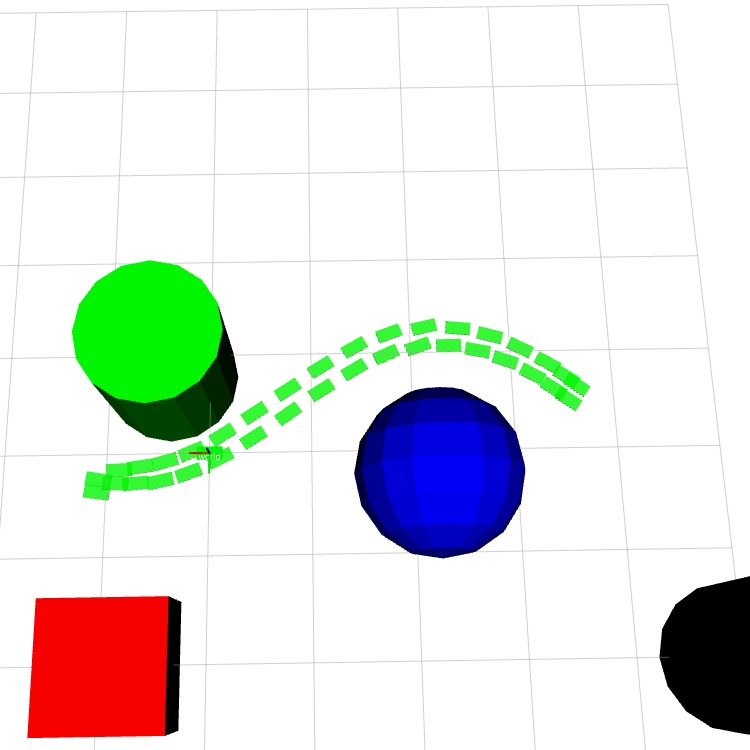

In [31]:
save_screenshot(250,150,1000,900, FIG_FILE_NAME +   'contact.png', False) 


In [65]:
#transform foot_pose to zero location
init_pose = 0.5*(foot_pose[0]+foot_pose[1])
T_init = PosetoMat(init_pose)
T_init_inv = np.linalg.inv(T_init)
foot_pose_mod = transform_foot_poses(foot_pose, T_init_inv)
foot_pose_mod = add_intermediate(foot_pose_mod)
#foot_pose_mod = foot_pose_mod[:30]


#predict the movement to follow the foot_pose
func = gpr#nn
traj_list, foot_list, T_lefts_list, T_rights_list, data_phases  = predict_multistep(foot_pose_mod, func=func)
clear_output()

print 'visualizing'

In [1]:
for i,traj in enumerate(traj_list):
    cur_foot_pose = foot_list[i]
    cur_foot_pose = transform_foot_poses(cur_foot_pose, T_init)
    foot_marker.publish(cur_foot_pose)
    traj = transform_traj(traj,T_init)
    #viz.set_dof(traj[0])
    #viz.set_rate(2000)

    '''for j,index in enumerate(np.arange(0,3350,200)):
        viz.set_dof(traj[index])
        time.sleep(0.01)
        save_screenshot(200,200,1000,1000, FIG_FILE_NAME +  str(fig_index) + '.png', False) 
        fig_index +=1
        print fig_index
    clear_output()
    '''

    viz.vis_traj(traj)

NameError: name 'traj_list' is not defined

In [25]:
os.system('ffmpeg -r 25 -start_number 0 -i /home/rli/temp/wb_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p /home/rli/temp/wb0.mp4')
os.system('rm /home/rli/temp/wb*.png')